In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv('/content/drive/MyDrive/GitHub Project/Climate/DailyDelhiClimateTrain.csv',index_col=[0],parse_dates=[0]) #把第 0列当作dates
data_test = pd.read_csv('/content/drive/MyDrive/GitHub Project/Climate/DailyDelhiClimateTest.csv', index_col=[0], parse_dates=[0])

In [3]:
data_train.rename(columns={'meantemp': 'temp'}, inplace = True)
data_test.rename (columns={'meantemp': 'temp'}, inplace = True)
data_train.shape, data_test.shape

((1462, 4), (114, 4))

In [4]:
data_train.head(), data_test.head()

(                 temp   humidity  wind_speed  meanpressure
 date                                                      
 2013-01-01  10.000000  84.500000    0.000000   1015.666667
 2013-01-02   7.400000  92.000000    2.980000   1017.800000
 2013-01-03   7.166667  87.000000    4.633333   1018.666667
 2013-01-04   8.666667  71.333333    1.233333   1017.166667
 2013-01-05   6.000000  86.833333    3.700000   1016.500000,
                  temp   humidity  wind_speed  meanpressure
 date                                                      
 2017-01-01  15.913043  85.869565    2.743478     59.000000
 2017-01-02  18.500000  77.222222    2.894444   1018.277778
 2017-01-03  17.111111  81.888889    4.016667   1018.333333
 2017-01-04  18.700000  70.050000    4.545000   1015.700000
 2017-01-05  18.388889  74.944444    3.300000   1014.333333)

In [5]:
df_info = pd.concat([data_train.isna().sum(), data_train.nunique(), data_train.dtypes], axis= 1)
df_info.columns = ['missing', 'number of unique', 'data type']
df_info

,missing,number of unique,data type
temp,0,617,float64
humidity,0,897,float64
wind_speed,0,730,float64
meanpressure,0,626,float64


# **EDA**

In [6]:
df = data_train.copy()

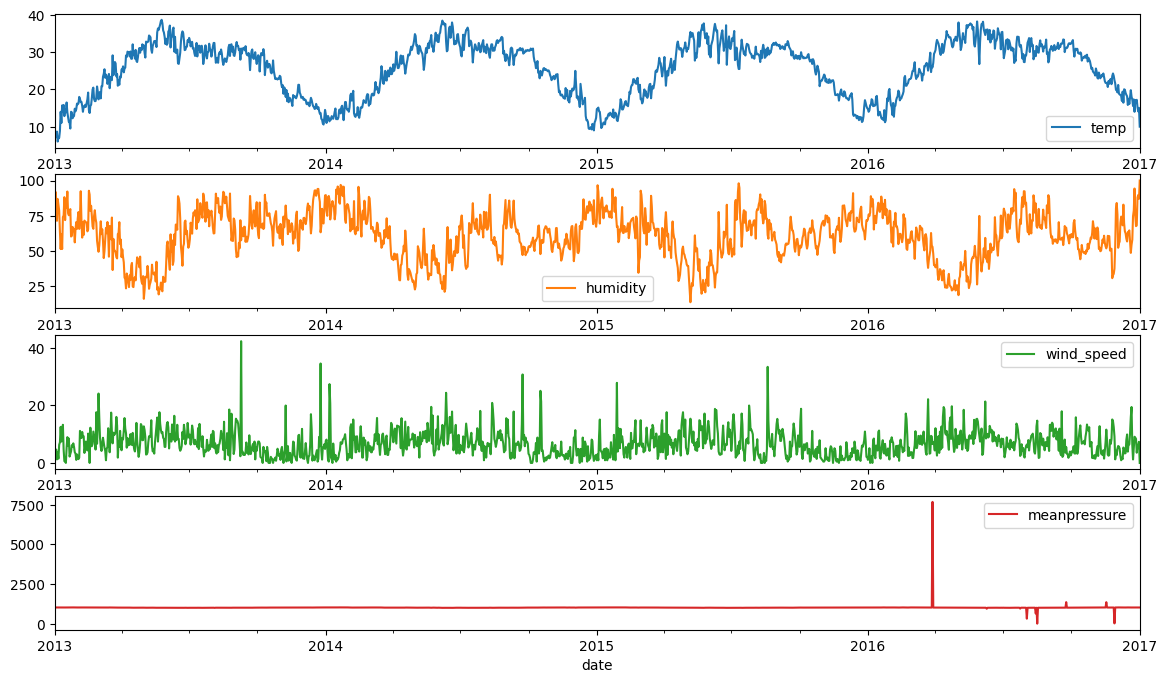

In [7]:
df.plot(subplots = True , layout = (4,1) , figsize = (14,8) , sharex= False) #最后一个是所有图不是共享一个x axis
plt.show()

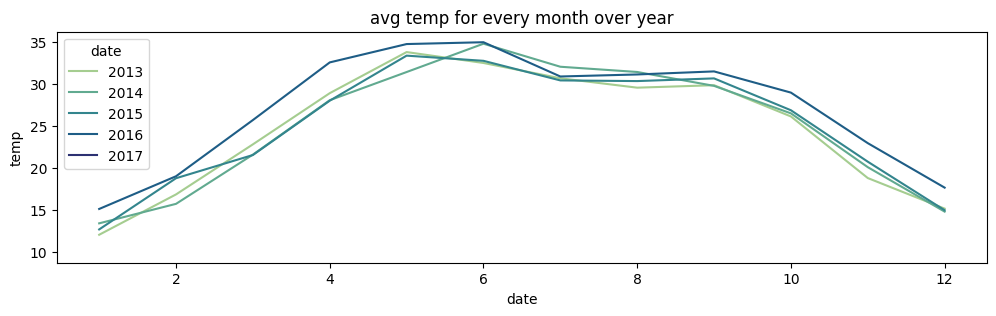

In [47]:
plt.figure(figsize = (12,3))
sns.lineplot(df ,x = df.index.month ,y = 'temp' , hue = df.index.year ,
             palette='crest' , errorbar = None)
plt.title('avg temp for every month over year')
plt.show()

In [8]:
df.isnull().sum()

,0
temp,0
humidity,0
wind_speed,0
meanpressure,0


In [9]:
df.duplicated().sum()

0

In [10]:
df.head()

,temp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


meanpressure looks very wired, it has outliers. Other data have a seasonal pattern.

# **Prediction Column: Temperatures**

In [11]:
data = df['temp']
data = pd.DataFrame(data)

data = data.values
data.shape

(1462, 1)

# **Normalizing Data**

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(data)

In [13]:
scaled_data

array([[0.12227074],
       [0.04279476],
       [0.0356623 ],
       ...,
       [0.24745269],
       [0.276718  ],
       [0.12227074]])

In [14]:
scaled_data.shape

(1462, 1)

# **Splitting the Data**

In [15]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print('Train Size:', train_size, 'Test Size:', test_size)

Train Size: 1096 Test Size: 366


# **Creating training set**

In [16]:
train_data = scaled_data[:train_size, :]
train_data.shape

(1096, 1)

In [17]:
x_train = []
y_train = []
time_steps = 60

for i in range(time_steps, len(train_data)):
  x_train.append(train_data[i - time_steps: i, 0])
  y_train.append(train_data[i,0])

x_train = np.array(x_train)
y_train = np.array(y_train)


In [18]:
# Reshaping the input to 3D array [samples, time_steps, features].
x_train = np.reshape(x_train ,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1036, 60, 1)

# **LSTM Model**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_LSTM = Sequential([
    LSTM(50, return_sequences=True,input_shape = (x_train.shape[1], 1) ),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)

])

model_LSTM.compile(optimizer= "adamax", loss="mse", metrics=["mean_absolute_error"])


In [20]:
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from keras.callbacks import EarlyStopping

EarlyStopping = EarlyStopping(monitor="loss", patience=15, restore_best_weights=True)
history= model_LSTM.fit(x_train, y_train, epochs=10, batch_size=32,callbacks = [EarlyStopping])

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0900 - mean_absolute_error: 0.2195
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0084 - mean_absolute_error: 0.0725
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0060 - mean_absolute_error: 0.0621
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0054 - mean_absolute_error: 0.0579
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0052 - mean_absolute_error: 0.0571
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0051 - mean_absolute_error: 0.0562
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0053 - mean_absolute_error: 0.0585
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0053 - mean_absolute_error: 0.0575
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0048 - mean_absolute_error: 0.0546
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0047 - mean_absolute_error: 0.0538


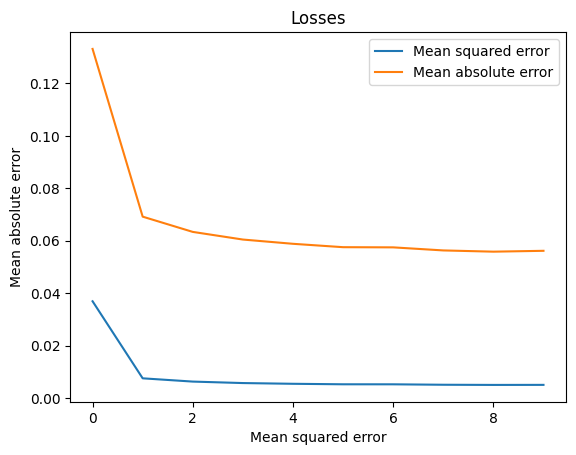

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.title("Losses")
plt.xlabel("Mean squared error")
plt.ylabel("Mean absolute error")
plt.legend(["Mean squared error", "Mean absolute error"])
plt.show()

# **Prediction**

# **Creating Test Data**

In [23]:
test_data = scaled_data[train_size - 60:, :]
x_test = []
y_test = []

for i in range(60, len(test_data)):
               x_test.append(test_data[i-60:i, 0])
               y_test.append(test_data[i, 0])

x_train = np.array(x_test)
y_train = np.array(y_test)

In [24]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
x_test.shape , y_test.shape

((366, 60, 1), (366,))

In [27]:
predictions_LSTM = model_LSTM.predict(x_test)

predictions_LSTM = scaler.inverse_transform(predictions_LSTM)
predictions_LSTM.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


(366, 1)

In [28]:
y_test = scaler.inverse_transform([y_test])

RMSE_LSTM = np.sqrt(np.mean( y_test - predictions_LSTM )**2).round(2)
RMSE_LSTM

0.01

In [29]:
preds_acts = pd.DataFrame(data={'Predictions':predictions_LSTM.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,14.428720,14.000000
1,14.561427,14.375000
2,14.656453,15.750000
3,14.786622,15.833333
4,14.936588,17.375000
...,...,...
361,17.375473,17.217391
362,17.293997,15.238095
363,17.155512,14.095238
364,16.935114,15.052632


In [30]:
y_train_flattened = y_train.flatten()

# Create a DataFrame with 'train' as the column name
train = pd.DataFrame(data=y_train_flattened, columns=['train'])

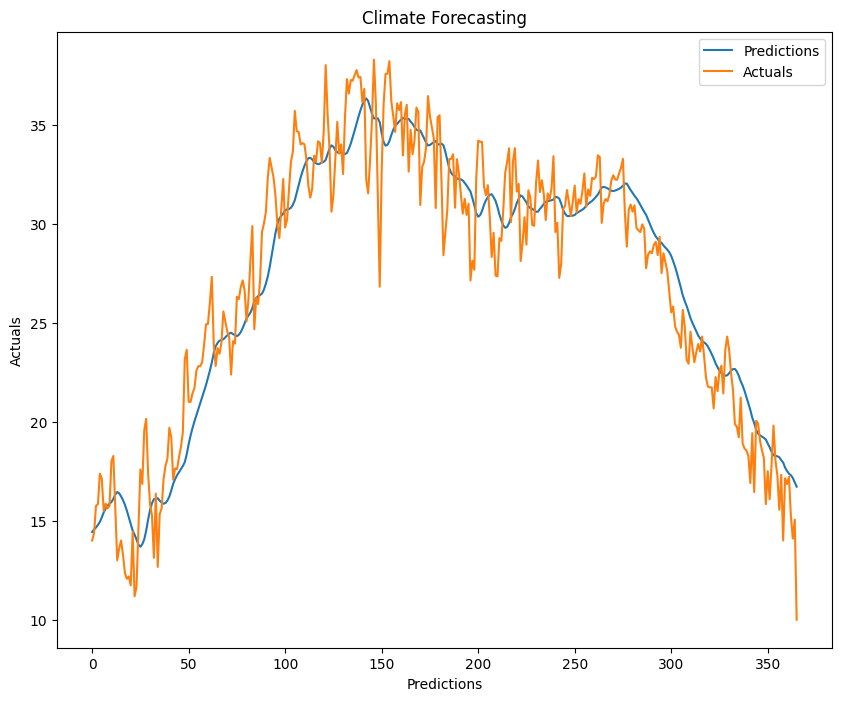

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(preds_acts["Predictions"])
plt.plot(preds_acts["Actuals"])
plt.title("Climate Forecasting")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.legend(["Predictions", "Actuals"])
plt.show()

# **Forcasting**

In [32]:
from datetime import timedelta

In [33]:
# Define the insert_end function
def insert_end(Xin, new_input):
    timestep = Xin.shape[1]  # 获取timestamp (样本数，timestamp, 特征数)
    Xin[:, :-1, :] = Xin[:, 1:, :]  # Shift sequence # 把输入序列向前移动一位（去掉最早的时间步）
    Xin[:, -1, :] = new_input  # Insert new input at the end 将新的预测值放到序列的最后一位
    return Xin

# Forecast future values
future = 50
forcast = []
Xin = x_test[-1:, :, :]  # Initialize with the last input of the test set # 使用测试集最后一个时间步作为预测的初始输入
time = []

for i in range(future):
    out = model_LSTM.predict(Xin, batch_size=5) # 基于当前输入进行预测
    forcast.append(out[0]) # 将预测值添加到预测列表中
    Xin = insert_end(Xin, out[0].reshape(1, 1, 1))  # 更新输入序列，把预测值作为下一个输入
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i)) # 记录预测的日期


forcasted_output = np.array(forcast).reshape(-1, 1)  # Adjust shape as needed


forcasted_output = scaler.inverse_transform(forcasted_output)

# Convert forecasted output to DataFrame with appropriate column names
forcasted_output_df = pd.DataFrame(forcasted_output, columns=['meantemp'])


date_df = pd.DataFrame(time, columns=['Date'])


df_result = pd.concat([date_df, forcasted_output_df], axis=1)


print(df_result.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━

In [34]:
df_result.head(50)

,Date,meantemp
0,2017-01-01,16.718832
1,2017-01-02,16.593134
2,2017-01-03,16.524611
3,2017-01-04,16.493797
4,2017-01-05,16.487541
5,2017-01-06,16.497145
6,2017-01-07,16.516941
7,2017-01-08,16.543270
8,2017-01-09,16.573812
9,2017-01-10,16.607080


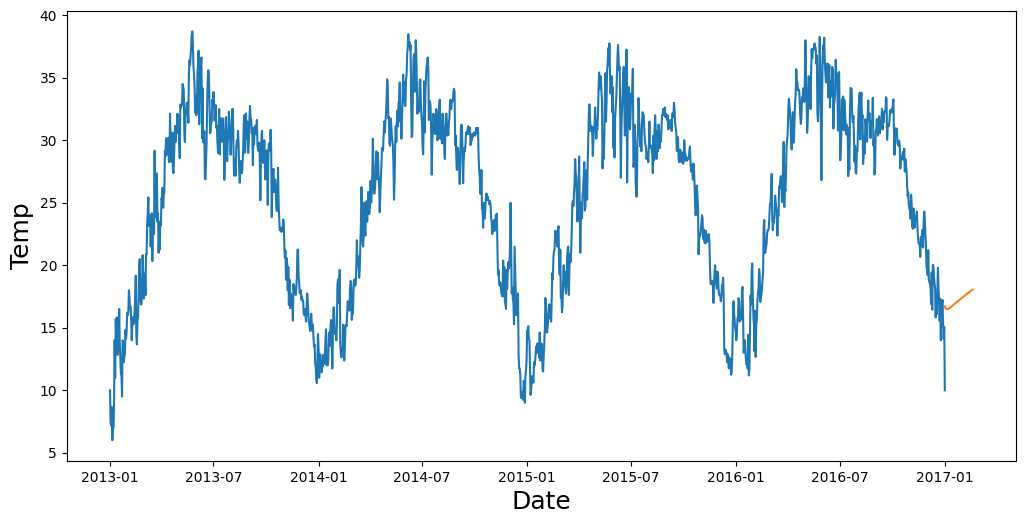

In [35]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(df['temp'])
plt.plot(df_result.set_index('Date')[['meantemp']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temp' ,fontsize=18)

plt.tight_layout()
plt.show()

# **GRU**

In [36]:
from tensorflow.keras.layers import GRU,Dense, Dropout
model_GRU = Sequential([
    GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # 输出层
])

model_GRU.compile(optimizer= "adamax", loss="mse", metrics=["mean_absolute_error"])

In [37]:
from keras.callbacks import EarlyStopping

EarlyStopping = EarlyStopping(monitor="loss", patience=15, restore_best_weights=True)
history= model_GRU.fit(x_train, y_train, epochs=10, batch_size=32,callbacks = [EarlyStopping])

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.2184 - mean_absolute_error: 0.3981
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0378 - mean_absolute_error: 0.1610
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0180 - mean_absolute_error: 0.1056
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0132 - mean_absolute_error: 0.0912
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0124 - mean_absolute_error: 0.0898
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0144 - mean_absolute_error: 0.0922
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0126 - mean_absolute_error: 0.0889
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0120 - mean_absolute_error: 0.0857
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0103 - mean_absolute_error: 0.0805
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0119 - mean_absolute_error: 0.0877


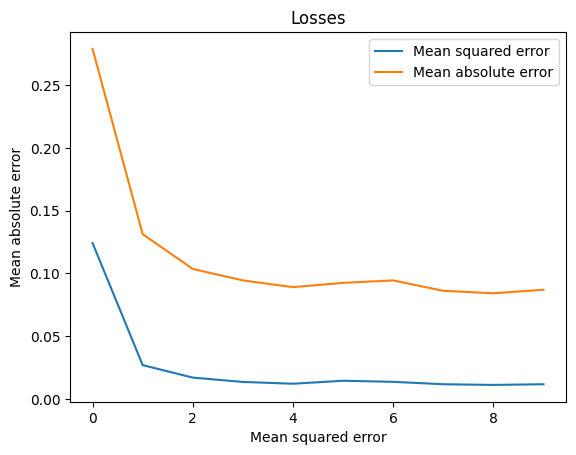

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.title("Losses")
plt.xlabel("Mean squared error")
plt.ylabel("Mean absolute error")
plt.legend(["Mean squared error", "Mean absolute error"])
plt.show()

In [40]:
predictions_GRU = model_GRU.predict(x_test)

predictions_GRU = scaler.inverse_transform(predictions_GRU)
predictions_GRU.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(366, 1)

In [41]:
test_data = scaled_data[train_size - 60:, :]
x_test = []
y_test = []

for i in range(60, len(test_data)):
               x_test.append(test_data[i-60:i, 0])
               y_test.append(test_data[i, 0])

x_train = np.array(x_test)
y_train = np.array(y_test)

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape , y_test.shape

((366, 60, 1), (366,))

In [42]:
y_test = scaler.inverse_transform([y_test])

RMSE_GRU = np.sqrt(np.mean( y_test - predictions_GRU )**2).round(2)
RMSE_GRU

0.28

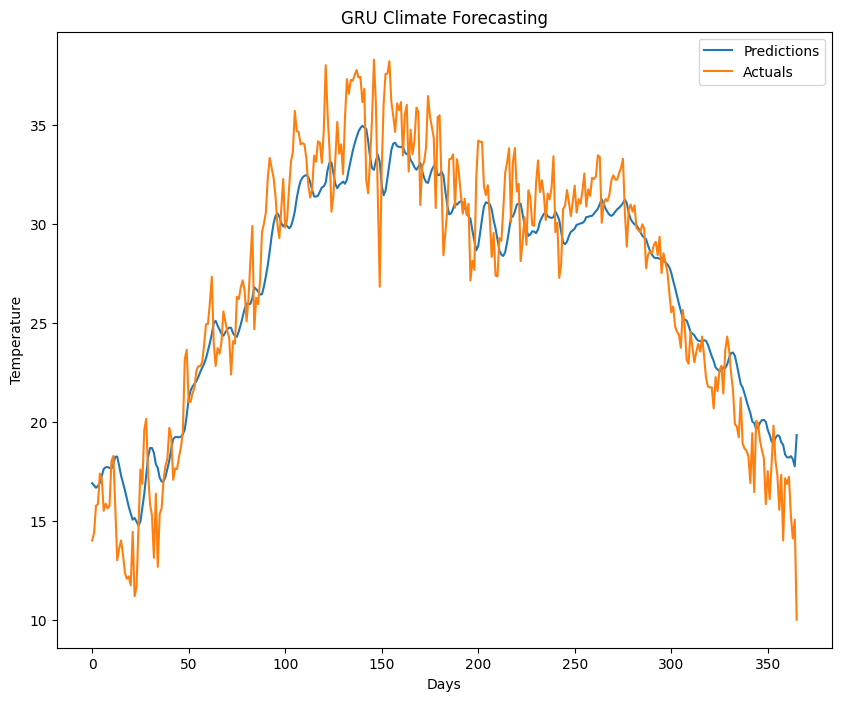

In [55]:
# 可视化GRU预测结果
preds_acts_GRU = pd.DataFrame(data={'Predictions': predictions_GRU.flatten(), 'Actuals': y_test.flatten()})

plt.figure(figsize=(10, 8))
plt.plot(preds_acts_GRU["Predictions"])
plt.plot(preds_acts_GRU["Actuals"])
plt.title("GRU Climate Forecasting")
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.legend(["Predictions", "Actuals"])
plt.show()


# **SARIMA**

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model_SARIMA = SARIMAX(scaled_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit_SARIMA = model_SARIMA.fit(disp=False)


predictions_SARIMA = model_fit_SARIMA.forecast(steps=len(x_test))


predictions_SARIMA = scaler.inverse_transform(predictions_SARIMA.reshape(-1, 1))


RMSE_SARIMA = np.sqrt(np.mean((y_test.flatten() - predictions_SARIMA.flatten()) ** 2)).round(2)


print(f"SARIMA RMSE: {RMSE_SARIMA}")


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA RMSE: 17.64


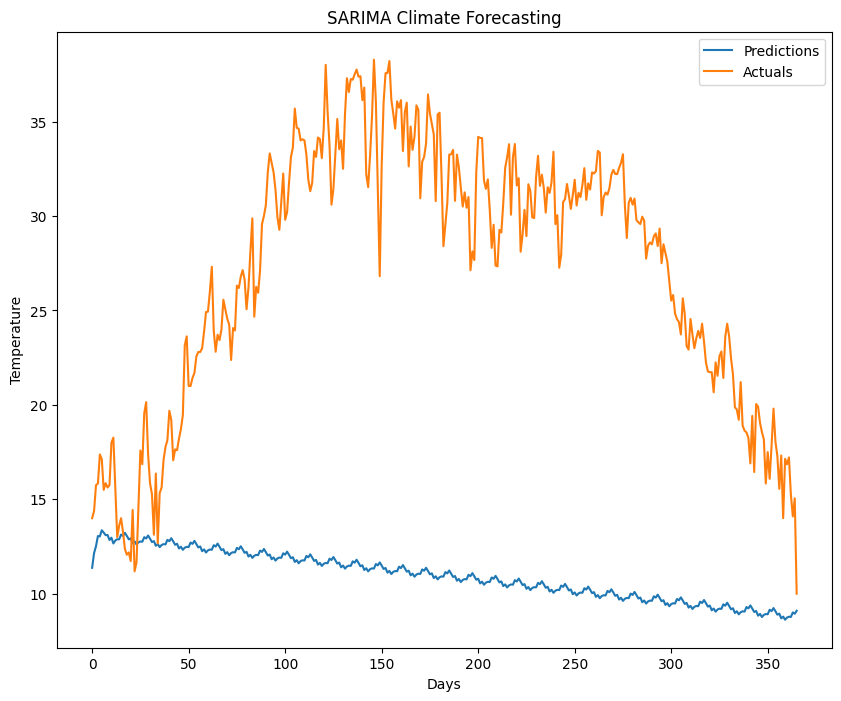

In [57]:

preds_acts_SARIMA = pd.DataFrame(data={'Predictions': predictions_SARIMA.flatten(), 'Actuals': y_test.flatten()})

plt.figure(figsize=(10, 8))
plt.plot(preds_acts_SARIMA["Predictions"])
plt.plot(preds_acts_SARIMA["Actuals"])
plt.title("SARIMA Climate Forecasting")
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.legend(["Predictions", "Actuals"])
plt.show()


In [58]:
print(f"LSTM RMSE: {RMSE_LSTM}")
print(f"GRU RMSE: {RMSE_GRU}")
print(f"SARIMA RMSE: {RMSE_SARIMA}")


LSTM RMSE: 0.01
GRU RMSE: 0.28
SARIMA RMSE: 17.64


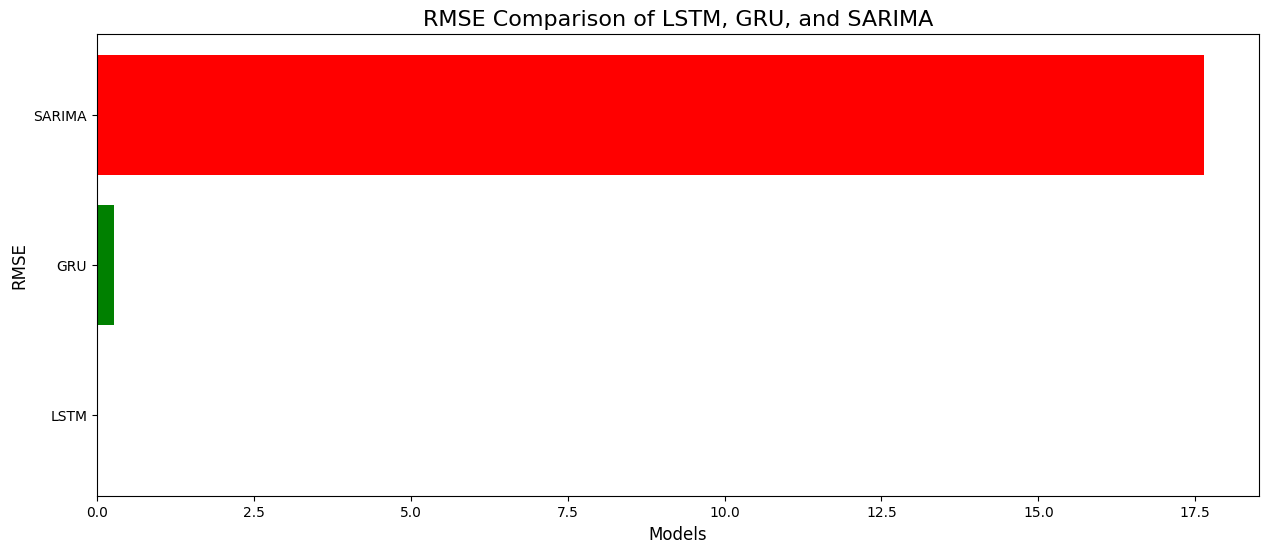

In [61]:
rmse_values = [RMSE_LSTM, RMSE_GRU, RMSE_SARIMA]
model_names = ['LSTM', 'GRU', 'SARIMA']

plt.figure(figsize=(15, 6))
plt.barh(model_names, rmse_values, color=['blue', 'green', 'red'])


plt.title('RMSE Comparison of LSTM, GRU, and SARIMA', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.show()